
---

## **Atividade 1 — Classificação Supervisionada**

Nesta atividade, você deve **comparar quatro diferentes paradigmas de aprendizado de máquina**: probabilísticos, simbólicos, conexionistas e estatísticos.

> **Importante:** Durante a **etapa de inferência**, o modelo **só poderá utilizar o conteúdo textual** (`content`) do post para prever o engajamento. Informações como `reactions` e `comments` devem ser utilizadas apenas na etapa de treinamento, se desejar, mas não podem ser usadas como entrada no momento da predição de novos posts (eles não estarão disponíveis em inferência).

Para avaliação, será disponibilizado um arquivo de teste contendo **novas postagens sem o rótulo de engajamento**, e cada aluno deverá submeter suas **previsões finais de engajamento** para essas novas entradas.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import numpy as np
import pandas as pd


In [2]:
df = pd.read_pickle('../data/df_social_data_train.pkl')
df

,anon_id,content,reactions,comments,score,engagement
0,afb338bc4e80e811be481b27807934c5,Robert Lerman writes that achieving a healthy...,12,1,13,low
1,afb338bc4e80e811be481b27807934c5,"National disability advocate Sara Hart Weir, ...",11,0,11,low
2,afb338bc4e80e811be481b27807934c5,NaN,15,0,15,low
3,afb338bc4e80e811be481b27807934c5,Exploring in this months Talent Management & H...,44,0,44,low
4,afb338bc4e80e811be481b27807934c5,I count myself fortunate to have spent time wi...,22,2,24,low
...,...,...,...,...,...,...
23803,ecc9ab53ac5a897358b35118221ea367,Check out my interview with @AaronBerson ! I w...,5,0,5,low
23804,ecc9ab53ac5a897358b35118221ea367,Check out my interview with @MikeMax32CPA abou...,3,0,3,low
23805,ecc9ab53ac5a897358b35118221ea367,Love! #radicalcpa,76,3,79,low
23806,ecc9ab53ac5a897358b35118221ea367,Did you know next year is going to be the best...,1,0,1,low


In [3]:
# pre-processar e extrair caracteristicas dos dados para construir a tabela atributo-valor
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

/home/thzero/Documentos/Disciplinas/IA/IA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/thzero/Documentos/Disciplinas/IA/IA/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
df = df.dropna()

In [5]:
df['features'] = list(model.encode(df['content'].tolist(), show_progress_bar=True))

df

Batches: 100%|██████████| 704/704 [07:52<00:00,  1.49it/s]
/tmp/ipykernel_254499/1892182183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features'] = list(model.encode(df['content'].tolist(), show_progress_bar=True))


,anon_id,content,reactions,comments,score,engagement,features
0,afb338bc4e80e811be481b27807934c5,Robert Lerman writes that achieving a healthy...,12,1,13,low,"[-0.011695226, 0.027859222, 0.036047406, -0.03..."
1,afb338bc4e80e811be481b27807934c5,"National disability advocate Sara Hart Weir, ...",11,0,11,low,"[-0.026237344, -0.064887136, -0.0078637935, 0...."
3,afb338bc4e80e811be481b27807934c5,Exploring in this months Talent Management & H...,44,0,44,low,"[-0.023109017, -0.020342512, 0.035548195, -0.0..."
4,afb338bc4e80e811be481b27807934c5,I count myself fortunate to have spent time wi...,22,2,24,low,"[-0.05438446, 0.0031936788, -0.06155947, 0.011..."
5,afb338bc4e80e811be481b27807934c5,Online job platforms are a different way of wo...,21,1,22,low,"[-0.068378255, -0.06278064, -0.010366013, -0.0..."
...,...,...,...,...,...,...,...
23803,ecc9ab53ac5a897358b35118221ea367,Check out my interview with @AaronBerson ! I w...,5,0,5,low,"[-0.07402989, 0.008327075, 0.0050209165, 0.041..."
23804,ecc9ab53ac5a897358b35118221ea367,Check out my interview with @MikeMax32CPA abou...,3,0,3,low,"[-0.03911017, 0.006784756, -0.011407444, 0.041..."
23805,ecc9ab53ac5a897358b35118221ea367,Love! #radicalcpa,76,3,79,low,"[-0.066774145, -0.0118888905, 0.0026477212, -0..."
23806,ecc9ab53ac5a897358b35118221ea367,Did you know next year is going to be the best...,1,0,1,low,"[-0.07542419, 0.017530847, 0.023634866, -0.043..."


In [6]:
df['engagement'] = df['engagement'].map({'low': 0, 'high': 1})

/tmp/ipykernel_254499/3581441875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['engagement'] = df['engagement'].map({'low': 0, 'high': 1})


In [7]:
labels = df['engagement'].to_numpy()
data = np.array(df['features'].tolist())

In [8]:
kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

def applyKfold(data, label, classifier):

    accVet = []
    f1Vet = []
    f1MacroVet = []

    for train_index, test_index in kf.split(data, label):
        # particição dos dados em conjunto de treino / teste
        data_train, data_test = data[train_index], data[test_index]
        label_train, label_test = label[train_index], label[test_index]


        # classificador
        clf = classifier
        clf.fit(data_train, label_train)

        # predição
        y_pred = clf.predict(data_test)

        # avaliação
        acc = accuracy_score(label_test, y_pred)
        f1 = f1_score(label_test, y_pred)
        f1_macro = f1_score(label_test, y_pred, average='macro')

        accVet.append(acc)
        f1Vet.append(f1)
        f1MacroVet.append(f1_macro)


    return (accVet, f1Vet, f1MacroVet)






---
## Abordagem **Probabilística** - Naive Bayes

In [9]:
acc, f1, f1Macro = applyKfold(data, labels, GaussianNB())
print("Accuracy Score: ", round(np.mean(acc), 4))
print("F1 Score: ", round(np.mean(f1), 4))
print("F1 Macro Score: ", round(np.mean(f1Macro), 4))

Accuracy Score:  0.6919
F1 Score:  0.4346
F1 Macro Score:  0.6114



---
## Abordagem **Simbólica** - Decision Tree

In [10]:
acc, f1, f1Macro = applyKfold(data, labels, DecisionTreeClassifier(criterion='entropy'))
print("Accuracy Score: ", round(np.mean(acc), 4))
print("F1 Score: ", round(np.mean(f1), 4))
print("F1 Macro Score: ", round(np.mean(f1Macro), 4))

Accuracy Score:  0.6989
F1 Score:  0.3224
F1 Macro Score:  0.5644



---
## Abordagem **Conexionista** - Multilayer Perceptron

In [86]:
# MLP (com regularização e early stopping)
value_1 = 32
value_2 = 16
value_3 = 2

mlp = Sequential()
mlp.add(Dense(value_1, input_shape=(data.shape[1],), activation='tanh'))
mlp.add(Dropout(0.1))
mlp.add(Dense(value_2, input_shape=(data.shape[1],), activation='tanh'))
mlp.add(Dropout(0.1))
mlp.add(Dense(1, input_shape=(data.shape[1],), activation='sigmoid'))

mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.summary()

/home/thzero/Documentos/Disciplinas/IA/IA/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_79 (Dense)                │ (None, 32)             │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,865 (50.25 KB)

 Trainable params: 12,865 (50.25 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

history = mlp.fit(
    X_train,
    y_train,
    epochs=1000,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/1000
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7795 - loss: 0.5169 - val_accuracy: 0.7934 - val_loss: 0.4687
Epoch 2/1000
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8010 - loss: 0.4564 - val_accuracy: 0.7946 - val_loss: 0.4647
Epoch 3/1000
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8057 - loss: 0.4417 - val_accuracy: 0.7982 - val_loss: 0.4618
Epoch 4/1000
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8119 - loss: 0.4388 - val_accuracy: 0.7993 - val_loss: 0.4584
Epoch 5/1000
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8058 - loss: 0.4452 - val_accuracy: 0.7982 - val_loss: 0.4593
Epoch 6/1000
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8133 - loss: 0.4374 - val_accuracy: 0.7993 - val_loss: 0.4592
Epoch 7/1000
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8140 - loss: 0.4356 - val_accuracy: 0.8018 - val_loss: 0.4571
Epoch 8/1000
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8122 - loss: 0.4358 - 

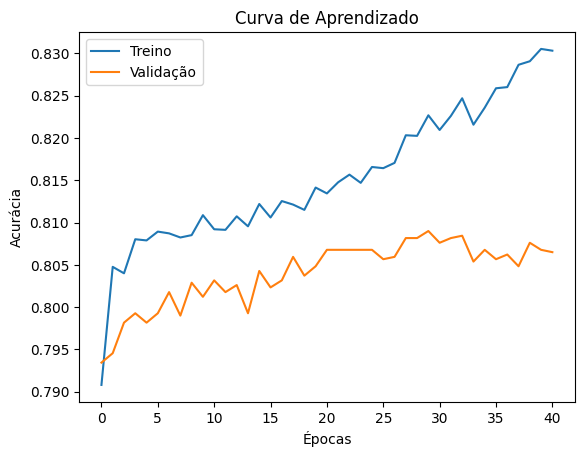

In [88]:
# Plotando curva de aprendizado
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title("Curva de Aprendizado")
plt.show()

In [89]:
# Avaliar no conjunto de teste
test_loss, test_acc = mlp.evaluate(X_test, y_test, verbose=1)
print(f"[MLP] Acurácia no teste final: {test_acc:.4f}, Loss: {test_loss:.4f}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8157 - loss: 0.4240
[MLP] Acurácia no teste final: 0.8095, Loss: 0.4292


In [ ]:
acc, f1, f1Macro = applyKfold(data, labels, MLPClassifier(alpha=1, max_iter=100, early_stopping=True))
print("Accuracy Score: ", round(np.mean(acc), 4))
print("F1 Score: ", round(np.mean(f1), 4))
print("F1 Macro Score: ", round(np.mean(f1Macro), 4))

Iteration 1, loss = 0.71360808
Validation score: 0.779970
Iteration 2, loss = 0.52660425
Validation score: 0.779970
Iteration 3, loss = 0.50934259
Validation score: 0.781450
Iteration 4, loss = 0.50674654
Validation score: 0.783917
Iteration 5, loss = 0.50522212
Validation score: 0.787864
Iteration 6, loss = 0.50469608
Validation score: 0.786877
Iteration 7, loss = 0.50459568
Validation score: 0.787370
Iteration 8, loss = 0.50373673
Validation score: 0.791317
Iteration 9, loss = 0.50376917
Validation score: 0.791811
Iteration 10, loss = 0.50344124
Validation score: 0.794277
Iteration 11, loss = 0.50312885
Validation score: 0.788357
Iteration 12, loss = 0.50337291
Validation score: 0.792304
Iteration 13, loss = 0.50263479
Validation score: 0.789837
Iteration 14, loss = 0.50295139
Validation score: 0.793291
Iteration 15, loss = 0.50309294
Validation score: 0.789344
Iteration 16, loss = 0.50340617
Validation score: 0.791317
Iteration 17, loss = 0.50342184
Validation score: 0.791317
Iterat


---
## Abordagem **Estatística**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# classificador
clf_svc = SVC(kernel="rbf", C=10, gamma='scale', max_iter=10000)
clf_svc.fit(X_train_scaled, y_train)

# predição
y_pred = clf_svc.predict(X_test_scaled)

# avaliação
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Accuracy Score:", round(acc, 4))
print("F1 Score:", round(f1, 4))
print("F1 Macro Score:", round(f1_macro, 4))

/home/thzero/Documentos/Disciplinas/IA/IA/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy Score: 0.8299
F1 Score: 0.5352
F1 Macro Score: 0.7155
